In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from pathlib import Path
from glob import glob
from datetime import datetime
import spacy

nlp = spacy.load("en_core_web_sm")


In [2]:
if Path("./data/df_quotes.pickle").is_file():
    df_quotes = pd.read_pickle("./data/df_quotes.pickle")
else:
    df_quotes = pd.read_json(
        "data/natural_disaster_quotes.json.bz2", lines=True, compression="bz2"
    )
    df_quotes.to_pickle("./data/df_quotes.pickle")

print(f"Number of quotes: %d" % len(df_quotes.index))


Number of quotes: 1480711


In [3]:
# Turn the parquets into exploded pickles
files = sorted(glob("data/speaker_attributes.parquet/part*"))
for (i, f) in enumerate(files):
    if Path("data/speaker_chunks/chunk_" + str(i) + ".pickle").is_file():
        continue
    else:
        chunk = pd.read_parquet(f, engine="pyarrow").explode("aliases")
        chunk = chunk[chunk.aliases.isin(df_quotes.speaker)]
        chunk.to_pickle("data/speaker_chunks/chunk_" + str(i) + ".pickle")


In [4]:
# Regroup the chunks into one
files = sorted(glob("data/speaker_chunks/chunk*"))
chunks = pd.DataFrame()

for f in files:
    chunk = pd.read_pickle(f)
    chunks = chunks.append(chunk)

chunks.head(2)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3,President George W. Bush,[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
3,George Bush,[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"


In [5]:
# Load the Wikidata nodes
df_labels = pd.read_csv(
    "data/wikidata_labels_descriptions_quotebank.csv.bz2",
    compression="bz2",
    index_col="QID",
)
df_labels.head()


,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [6]:
# Turn the wikinodes into human readable labels
cols = [
    "nationality",
    "occupation",
    "party",
    "academic_degree",
    "candidacy",
    "religion",
]
for col in cols:
    print(col)
    chunks[col] = chunks[col].apply(
        lambda l: [df_labels.loc[q]["Label"] for q in l] if l is not None else l
    )

speakers = chunks
chunks.head(2)
print(chunks.candidacy.iloc[1])

nationality
occupation
party
academic_degree
candidacy
religion
['2000 United States presidential election', '2004 United States presidential election', '1998 Texas gubernatorial election', '1978 United States House of Representatives elections']


<AxesSubplot:>

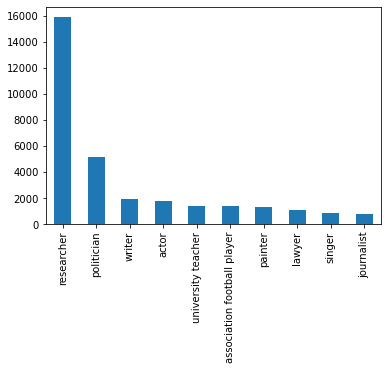

In [7]:
# Now to the fun stuff...

# Count and display the profession of the speakers
speakers.occupation.explode().value_counts().head(10).plot(kind="bar")


<AxesSubplot:>

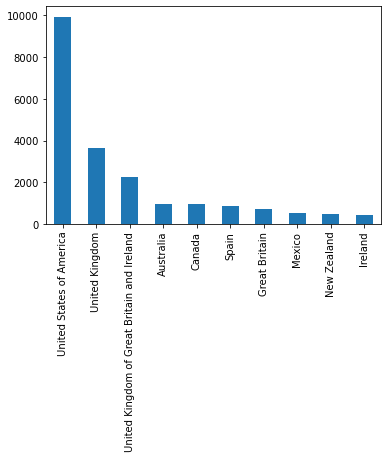

In [8]:
# Count and display Political party
speakers.nationality.explode().value_counts().head(10).plot(kind="bar")


<AxesSubplot:>

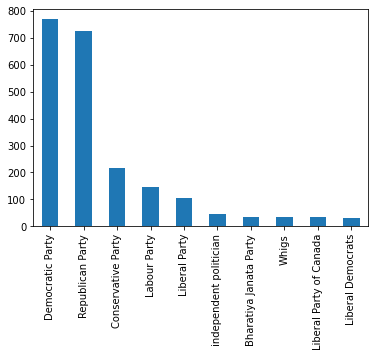

In [9]:
# Count and display Political party
chunks.party.explode().value_counts().head(10).plot(kind="bar")


In [10]:
# We will need to do matching later.....
# Do topic detection on the democrats and the republicans

## Get left wingers TODO? include more parties than dems
democrats = speakers[
    speakers.party.apply(lambda l: "Democratic Party" in l if l is not None else False)
]

## Get right wingers TODO? include more parties than repubs
republicans = speakers[
    speakers.party.apply(lambda l: "Republican Party" in l if l is not None else False)
]

## Get lefties quotes
left_quotes = df_quotes[df_quotes.speaker.isin(democrats.aliases)]
left_book = left_quotes.quotation.str.cat(sep="\n")
with open("data/left_book.txt", "w") as f:
    f.write(left_book)

## Get righties quotes
right_quotes = df_quotes[df_quotes.speaker.isin(republicans.aliases)]
right_book = right_quotes.quotation.str.cat(sep="\n")
with open("data/right_book.txt", "w") as f:
    f.write(right_book)


In [42]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i : i + n]


# Get the quotes into chunks
from nltk.corpus import PlaintextCorpusReader

books = PlaintextCorpusReader("data", "(researcher|politician)_book.txt")
print(books.fileids())
limit = 600
size = 50

chunks = list()
chunk_class = list()
book_id = {f: n for n, f in enumerate(books.fileids())}  # dictionary of books

for f in books.fileids():
    sentences = books.sents(f)
    print(f, ":")
    print("Num of sentences:", len(sentences))

    chunks_of_sents = [x for x in get_chunks(sentences, size)]
    chs = list()

    for c in chunks_of_sents:
        grouped_chunk = list()
        for sent in c:
            grouped_chunk.extend(sent)
        chs.append(" ".join(grouped_chunk))
    print("Num of chunks:", len(chs), "\n")

    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])


['politician_book.txt', 'researcher_book.txt']
politician_book.txt :
Num of sentences: 67624
Num of chunks: 1353 

researcher_book.txt :
Num of sentences: 137120
Num of chunks: 2743 



In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(chunks)

print("Number of samples:", X.toarray().shape[0])
print("Number of features:", X.toarray().shape[1])

Y = chunk_class

X, Y = shuffle(X, Y, random_state=0)

# split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


Number of samples: 1200
Number of features: 35875


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

accs = []

scaler = preprocessing.MaxAbsScaler()

X_scaled = X_train.log1p()
X_scaled = scaler.fit(X_scaled).transform(X_scaled)

# the grid of regularization parameter
grid = [0.01, 0.1, 1, 10, 100, 1000, 10000]

for c in grid:
    print("----", c)

    # initialize the classifier
    # Increase max iter by a lot because scaling gave worst results, but this
    # causes it to take a lot of time to compute.... using MaxAbsScaler was
    # recommended for sparse inputs but it gives worse results than to simply
    # increase the number of iterations
    clf = LogisticRegression(random_state=0, C=c) 

    # crossvalidate
    scores = cross_val_score(clf, X_scaled, Y_train, cv=10)
    accs.append(np.mean(scores))


---- 0.01
---- 0.1
---- 1
---- 10
---- 100
---- 1000
---- 10000


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Text(0, 0.5, 'Crossvalidation accuracy')

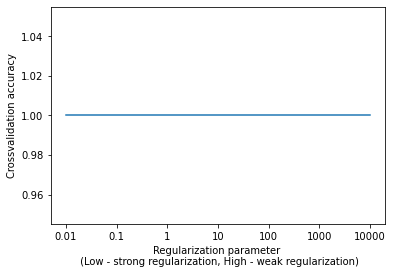

In [45]:
print(accs)
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')


In [46]:
clf = LogisticRegression(random_state=0, C = 100, max_iter=1000).fit(X_scaled, Y_train)

#predict on the test set
X_scaled_test = X_test.log1p()
X_scaled_test = scaler.fit(X_scaled_test).transform(X_scaled_test)
print('Accuracy:',clf.score(X_scaled_test,Y_test))

Accuracy: 0.9958333333333333


In [47]:
coefs=clf.coef_[0]
top_three = np.argpartition(coefs, -20)[-20:]

print(np.array(vectorizer.get_feature_names_out())[top_three])

['bit' 'team' 'able' 'can' 'which' 'so' 'really' 'come' 'snow' 'water'
 'risk' 'still' 'biological' 'there' 'chemicals' 'fires' 'between'
 'community' 'season' 'drought']


## Topic detection

In [48]:
# Get the chunks again (into smaller chunks)
book_id = {f: n for n, f in enumerate(books.fileids())}  # dictionary of books
chunks = list()
chunk_class = (
    list()
)  # this list contains the original book of the chunk, for evaluation

limit = 60  # how many chunks total
size = 50  # how many sentences per chunk/page

for f in books.fileids():
    sentences = books.sents(f)
    print(f)
    print("Number of sentences:", len(sentences))

    # create chunks
    chunks_of_sents = [
        x for x in get_chunks(sentences, size)
    ]  # this is a list of lists of sentences, which are a list of tokens
    chs = list()

    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:", len(chs), "\n")

    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])


politician_book.txt
Number of sentences: 67624
Number of chunks: 1353 

researcher_book.txt
Number of sentences: 137120
Number of chunks: 2743 



In [49]:
STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(chunks, batch_size = 10):
    ents = doc.ents
    
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    doc = [token for token in doc if token not in STOP_WORDS and len(token) > 2]
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
# print(docs)
del(processed_docs)


In [50]:
from gensim.models.phrases import Phrases

bigrams = Phrases(docs)

for idx in range(len(docs)):
    for token in bigrams[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [51]:
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

max_freq = 0.6
min_wordcount = 3

dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 4016
Number of chunks: 120


In [52]:
# models
from gensim.models import LdaMulticore

params = {"passes": 10, "random_state": 0}
base_models = dict()
model = LdaMulticore(
    corpus=corpus,
    num_topics=2,
    id2word=dictionary,
    workers=6,
    passes=params["passes"],
    random_state=params["random_state"],
)


In [53]:
model.show_topics(num_words=20)

[(0,
  '0.003*"bushfire" + 0.003*"home" + 0.003*"hurricane" + 0.003*"weather" + 0.002*"high" + 0.002*"cause" + 0.002*"tell" + 0.002*"Fire" + 0.002*"family" + 0.002*"place" + 0.002*"provide" + 0.002*"burn" + 0.002*"try" + 0.002*"little" + 0.002*"week" + 0.002*"system" + 0.002*"fight" + 0.002*"important" + 0.002*"event" + 0.002*"hard"'),
 (1,
  '0.007*"kill" + 0.005*"Soleimani" + 0.005*"Trump" + 0.004*"attack" + 0.004*"try" + 0.003*"United" + 0.003*"States" + 0.003*"Iran" + 0.003*"United_States" + 0.003*"military" + 0.003*"american" + 0.002*"Democrats" + 0.002*"President" + 0.002*"job" + 0.002*"strike" + 0.002*"action" + 0.002*"plan" + 0.002*"protect" + 0.002*"the United States" + 0.002*"Americans"')]

In [54]:
sorted(model[corpus[0]], key=lambda x: x[1], reverse=True)

[(1, 0.99803007)]

In [55]:
import pyLDAvis.gensim_models
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/home/luca/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp impo

## Sentiment analysis

In [64]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

with open("data/politician_book.txt", "r") as pol_f:
    pol_txt = [next(pol_f) for _ in range(1000)]

vs = analyzer.polarity_scores(pol_txt)

In [65]:
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Negative sentiment: 0.21
Neutral sentiment: 0.675
Positive sentiment: 0.115
Compound sentiment: -1.0


In [66]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

with open("data/researcher_book.txt", "r") as res_f:
    res_txt = [next(pol_f) for _ in range(1000)]

vs = analyzer.polarity_scores(res_txt)

In [67]:
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Negative sentiment: 0.125
Neutral sentiment: 0.763
Positive sentiment: 0.112
Compound sentiment: -1.0
